
# Variational Inference

The key idea in variational inference (VI) is to approximate the posterior with the closest member of a parametric family. This frames posterior inference as an optimization problem rather than a sampling problem.

## Setup

In [1]:
import matplotlib.pyplot as plt
import torch

from sklearn.linear_model import LogisticRegression
from torch.autograd.functional import hessian
from torch.distributions import Bernoulli, Beta, Binomial, MultivariateNormal, Normal
from tqdm.auto import trange

/Users/scott/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction

### Why Variational Inference?

MCMC methods are asymptotically unbiased (though for finite samples there is a transient bias that shrinks as $O(M^{-1})$). The real issue is variance: it only shrinks as $O(M^{-1/2})$.
    
**Motivation:** With finite computation, can we get better posterior estimates by trading asymptotic bias for smaller variance? 
    
**Idea:** approximate the posterior by with a simple, parametric form (though not strictly a Gaussian on the mode!). Optimize to find the approximation that is as "close" as possible to the posterior.


### Notation
This notation could be a bit confusing. Let,

- $\mbtheta \in \reals^D$ denote \textbf{all of latent variables and parameters} we wish to infer. 

- $p(\mbtheta \mid \mbx)$ denote the true posterior distribution we want to approximate.
    
- $q(\mbtheta; \mblambda)$ denote a parametric variational approximation to the posterior where...
    
- $\mblambda$ denotes the variational parameters that we will optimize.
    
- $D(q \, \| \, p)$ denote a divergence measure that takes in two distributions $q$ and $p$ and returns a measure of how similar they are.


### A view of variational inference
    
![Variational Inference](../slides/09_vi/vi.png "Variational Inference")


## Three Key Questions
    
1. What parametric family should we use?
2. How should we measure closeness?
3. How do we find the closest distribution in that family?

Different flavors of VI answer these questions differently


### Coordinate Ascent Variational Inference (CAVI)

1. What parametric family should we use?
- The **mean-field family**
2. How should we measure closeness?
- The **Kullback-Leibler (KL)** divergence.
3. How do we find the closest distribution in that family?
- **Coordinate ascent**, assuming we have a conditionally conjugate model.

### Gradient-based Variational Inference
1. What parametric family should we use?
- Pretty much any $q$, as long as we can sample from it and evaluate the log density.
2. How should we measure closeness?
- The **Kullback-Leibler (KL)** divergence.
3. How do we find the closest distribution in that family?
- **Stochastic gradient ascent** using Monte Carlo estimates of the ELBO and its gradient.

Gradient-based VI methods go under a few different names: black-box VI (BBVI), automatic differentiation VI (ADVI), fixed-form VI...

We'll focus on gradient-based methods in these notes.
    


## The Evidence Lower Bound (ELBO)

### Kullback-Leibler (KL) divergence
The KL divergence is a measure of closeness between two distributions. It is defined as,
\begin{align*}
    \KL{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbx} &= \E_{q(\mbtheta; \mblambda)} \left[ \log \frac{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbx)} \right] \\
    &= \E_{q(\mbtheta; \mblambda)} \left[ \log q(\mbtheta; \mblambda) \right] 
    - \E_{q(\mbtheta; \mblambda)} \left[ \log p(\mbtheta \mid \mbx) \right] 
    % \\
    % &= \underbrace{\bbH[q(\mbtheta; \mblambda), p(\mbtheta \mid \mbx)]}_{\text{cross entropy}} - \underbrace{\bbH[q(\mbtheta; \mblambda)]}_{\text{entropy}}
\end{align*}

It has some nice properties:
- It is non-negative.
- It is zero iff $q(\mbtheta; \mblambda) \equiv p(\mbtheta \mid \mbx)$.    
- It is defined in terms of expectations wrt $q$.

But it's also a bit weird... 
- It's asymmetric ($\KL{q}{p} \neq \KL{p}{q}$).


### The evidence lower bound (ELBO) from another angle
More concerning, the KL divergence involves the posterior $p(\mbtheta \mid \mbx)$, which we cannot compute!

But notice that...
\begin{align*}
    \KL{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbx}
    &= \E_{q(\mbtheta; \mblambda)} \left[ \log q(\mbtheta; \mblambda) \right] 
    - \E_{q(\mbtheta; \mblambda)} \left[ \log p(\mbtheta \mid \mbx) \right] \\
    &= \E_{q(\mbtheta; \mblambda)} \left[ \log q(\mbtheta; \mblambda) \right] 
    - \E_{q(\mbtheta; \mblambda)} \left[ \log p(\mbtheta, \mbx) \right] 
    + \E_{q(\mbtheta; \mblambda)}\left[ \log p(\mbx)\right] \\
    &= \underbrace{\E_{q(\mbtheta; \mblambda)} \left[ \log q(\mbtheta; \mblambda) \right] 
    - \E_{q(\mbtheta; \mblambda)} \left[ \log p(\mbtheta, \mbx) \right]}_{\text{negative ELBO}, -\cL(\mblambda)}
    + \underbrace{\log p(\mbx)}_{\text{evidence}}
\end{align*}
The first term involves the log joint, which we can compute, and the last term is independent of the variational parameters! 

Rearranging, we see that $\cL(\mblambda)$ is a lower bound on the marginal likelihood, aka the evidence,
\begin{align*}
\cL(\mblambda) &= \log p(\mbx) - \KL{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbx} 
\leq \log p(\mbx).
\end{align*}
That's why we call it the **evidence lower bound (ELBO)**.

### Viewer discretion advised...
    
[You have been warned...](https://www.youtube.com/watch?v=jugUBL4rEIM)


## Optimizing the ELBO

### Problem Statement

The optimal approximation is,
\begin{align*}
    q^\star(\mbtheta; \mblambda) 
    &= \mathrm{argmin}_{q \in \cQ} \KL{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbX)}
\end{align*}
or equivalently
\begin{align*}
    \mblambda^\star
    &= \mathrm{argmin}_{\mblambda \in \mbLambda} \KL{q(\mbtheta; \mblambda)}{p(\mbtheta \mid \mbX)} \\
    &= \mathrm{argmax}_{\mblambda \in \mbLambda} \cL(\mblambda)
\end{align*}
where $\cL(\mblambda)$ denotes the **evidence lower bound (ELBO)**,
\begin{align*}
    \cL(\mblambda) &= \E_{q(\mbtheta; \mblambda)} \left[\log p(\mbX, \mbtheta) - \log q(\mbtheta; \mblambda) \right]
\end{align*}

    


### Optimizing the ELBO with Coordinate Ascent
We want to find the variational parameters $\mblambda$ that minimize the KL divergence or, equivalently, maximize the ELBO.

For the mean-field family, the variational posterior factors over dimensions.
\begin{align*}
q(\theta; \lambda) &= \prod_{d=1}^D q(\theta_d; \lambda_d)
\end{align*}
Often, this factorization alloows for optimization via coordinate ascent. Consider optimizing the parameters for one factor $q(\theta_d; \lambda_d)$. As a function of $\lambda_d$, the ELBO is,
\begin{align*}
    \cL(\mblambda) 
    &= 
    \E_{q(\theta_d; \lambda_d)}\left[ \E_{q(\mbtheta_{\neg d}; \mblambda_{\neg d})} \left[ \log p(\mbtheta, \mbx) \right] \right] -
    \E_{q(\theta_d; \lambda_d)}[\log q(\theta_d; \lambda_d)] + c \\
    &= 
    \E_{q(\theta_d; \lambda_d)}\left[ \E_{q(\mbtheta_{\neg d}; \mblambda_{\neg d})} \left[ \log p(\theta_d \mid \mbtheta_{\neg_d}, \mbx) \right] \right] -
    \E_{q(\theta_d; \lambda_d)}[\log q(\theta_d; \lambda_d)] + c' \\
    &= -\KL{q(\theta_d; \lambda_d)}{\tilde{p}(\theta_d)} + c''
\end{align*}
where 
\begin{align*}
    \label{eq:cavi_form}
    \tilde{p}(\theta_d) &\propto
    \exp \left\{ \E_{q(\mbtheta_{\neg d}; \mblambda_{\neg d})} \left[ \log p(\theta_d \mid \mbtheta_{\neg d}, \mbx) \right] \right\}
\end{align*}
The ELBO is maximized wrt $\lambda_d$ when this KL is minimized; i.e. when $q(\theta_d ; \lambda_d) = \tilde{p}(\theta_d)$, the exponentiated expected log conditional probability, holding all other factors fixed.





### Optimizing the ELBO with stochastic gradient ascent
- **Idea:** Assume the variational parameters $\mbLambda$ are unconstrained (i.e., $\mbLambda = \mathbb{R}^Q$), then perform (stochastic) gradient ascent. 

- If the parameters are unconstrained and the ELBO is differentiable, we can use gradient ascent. 
Repeat:
\begin{align*}
    \mblambda &\leftarrow \mblambda + \alpha \nabla_{\mblambda} \cL(\mblambda) 
\end{align*}
with step size $\alpha$. Typically, you decrease the step size over iterations so that $\alpha_1 \geq \alpha_2 \geq \ldots$

- More generally, we can use _stochastic_ gradient ascent with an estimate of the gradient, $\widehat{\nabla}_{\mblambda} \cL(\mblambda)$, as long as it is unbiased,
\begin{align*}
    \E[\widehat{\nabla}_{\mblambda} \cL(\mblambda)] = \nabla_{\mblambda} \cL(\mblambda).
\end{align*}




### Monte Carlo gradient estimation
No problem! We'll just use ordinary Monte Carlo to estimate the gradient. But we run into a problem...
\begin{align*}
\nabla_{\mblambda} \cL(\mblambda) 
&= \nabla_{\mblambda} \E_{q(\mbtheta; \mblambda)} \left[ \log p(\mbx, \mbtheta) - \log q(\mbtheta; \mblambda) \right] \\
&\textcolor{red}{\neq} \;  \E_{q(\mbtheta; \mblambda)} \left[ \nabla_{\mblambda} \left(\log p(\mbx, \mbtheta) - \log q(\mbtheta; \mblambda)\right) \right].
\end{align*}

**Problem:** Why can't we simply bring the gradient inside the expectation?




### The score function gradient estimator
The basic problem is that the variational parameters $\mblambda$ determine the distribution we are taking an expectation under.  However, there are a few ways to obtain unbiased estimates of the gradient.

One approach is called the **score function gradient estimator** or the **REINFORCE estimator**. It is based on the following identity,

\begin{align*}
    \nabla_{\mblambda} \log q(\mbtheta; \mblambda) &= \frac{\nabla_{\mblambda} q(\mbtheta; \mblambda)}{q(\mbtheta; \mblambda)}
\end{align*}
where the l.h.s. is called the score function of distribution $q$.

We can use this identity to obtain an unbiased estimate of the gradient of an expectation,
\begin{align*}
    \nabla_{\mblambda} \E_{q(\mbtheta; \mblambda)} \left[ h(\mbtheta) \right] 
    &= \nabla_{\mblambda} \int q(\mbtheta; \mblambda) \, h(\mbtheta) \dif \mbtheta \\
    &= \int \left(\nabla_{\mblambda} q(\mbtheta; \mblambda)\right) h(\mbtheta) \dif \mbtheta \\
    &= \int \left(q(\mbtheta; \mblambda) \nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right) h(\mbtheta)  \dif \mbtheta \\
    &= \E_{q(\mbtheta; \mblambda)} \left[ \left(\nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right) h(\mbtheta) \right]
\end{align*}
From this identity, we can obtain an unbiased Monte Carlo estimate,
\begin{align*}
    \widehat{\nabla}_{\mblambda} \E_{q(\mbtheta; \mblambda)}[h(\mbtheta)] &= \frac{1}{M} \sum_{m=1}^M \left[ \nabla_{\mblambda} \log q(\mbtheta^{(m)}; \mblambda) \, h(\mbtheta^{(m)}) \right]; 
    \qquad \mbtheta^{(m)} \iid{\sim} q(\mbtheta; \mblambda)
\end{align*}



### Notes
1. The exchange of the gradient and the integral is allowed as long as the dominated convergence theorem holds, and it usually does for ML applications.
    
2. The score function gradient estimator is broadly applicable; e.g. it works for discrete and continuous latent variables $\mbtheta$. We just need the log density to be continuously differentiable wrt $\mblambda$ and to be able to sample from $q$. 
    
3. If $h$ is a function of both $\mbtheta$ and $\mblambda$, you need to apply the product rule. This gives another term,
    \begin{align*}
    \nabla_{\mblambda} \E_{q(\mbtheta; \mblambda)} \left[ h(\mbtheta, \mblambda) \right] 
    &= \E_{q(\mbtheta; \mblambda)} \left[ \left(\nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right) h(\mbtheta, \mblambda) \right]
    + \E_{q(\mbtheta; \mblambda)} \left[ \nabla_{\mblambda} h(\mbtheta, \mblambda) \right]
    \end{align*}
  



### Control variates
Though broadly applicable, the score function estimator is often too high variance to be useful. This problem can often be mitigated with control variates.

Recall that the expectation of the score is zero,
\begin{align*}
    \E_{q(\mbtheta; \mblambda)} \left[ \nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right] 
    &= \int q(\mbtheta; \mblambda) \nabla_{\mblambda} \log q(\mbtheta; \mblambda) \dif \mbtheta \\
    &= \int \nabla_{\mblambda} q(\mbtheta; \mblambda) \dif \mbtheta \\
    &= \nabla_{\mblambda} \int q(\mbtheta; \mblambda) \dif \mbtheta \\
    &= \nabla_{\mblambda} 1 = 0.
\end{align*}
Thus, we can subtract off any **baseline** from the function of interest without changing the expectation, but potentially reducing variance substantially,
\begin{align*}
    \E_{q(\mbtheta; \mblambda)} \left[ h(\mbtheta)  \nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right] 
    &= \E_{q(\mbtheta; \mblambda)} \left[ (h(\mbtheta) - b)  \nabla_{\mblambda} \log q(\mbtheta; \mblambda)\right].
\end{align*}




### The pathwise gradient estimator
The pathwise gradient estimator has more requirements, but often performs better. Suppose $q(\mbtheta; \mblambda) = \cN(\mbtheta; \mbmu, \diag(\mbsigma^2))$, where $\mblambda = (\mbmu, \log \mbsigma^2)$ are the (unconstrained) variational parameters. Then,
\begin{align*}
    \mbtheta \sim q(\mbtheta; \mblambda) \quad \iff \quad
    \mbtheta &= r(\mblambda, \mbepsilon), \quad \mbepsilon \sim \cN(\mbzero, \mbI) 
\end{align*}
where $r(\mblambda, \mbepsilon) = \mbmu + \mbsigma \mbepsilon$ is a **reparameterization** of $\mbtheta$ in terms of parameters $\mblambda$ and ``noise'' $\mbepsilon$.

 We can use the **law of the unconscious statistician** to rewrite the expectations as,
\begin{align*}
    \E_{q(\mbtheta; \mblambda)} \left[h(\mbtheta, \mblambda) \right]
    &= \E_{\mbepsilon \sim \cN(\mbzero, \mbI)} \left[h(r(\mblambda, \mbepsilon), \mblambda) \right]
\end{align*}
The distribution that the expectation is taken under no longer depends on the parameters $\mblambda$, so we can simply take the gradient inside the expectation,
\begin{align*}
    \nabla_{\mblambda} \E_{q(\mbtheta; \mblambda)} \left[h(\mbtheta, \mblambda) \right]
    &=  \E_{\mbepsilon \sim \cN(\mbzero, \mbI)} \left[\nabla_{\mblambda} h(r(\mblambda, \mbepsilon), \mblambda) \right]
\end{align*}

Now we can use Monte Carlo to obtain an unbiased estimate of the final expectation.
\begin{align*}
    \widehat{\nabla}_{\mblambda} \E_{q(\mbtheta; \mblambda)} \left[h(\mbtheta, \mblambda) \right]
    &= \frac{1}{M} \sum_{m=1}^M \nabla_{\mblambda} h(r(\mblambda, \mbepsilon_m), \mblambda); & \epsilon_m \iid{\sim} \cN(\mbzero, \mbI)
\end{align*}



## Synthetic Demo

Let's use VI to approximate the posterior in the logistic regression example from previous lectures.

/Users/scott/anaconda3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


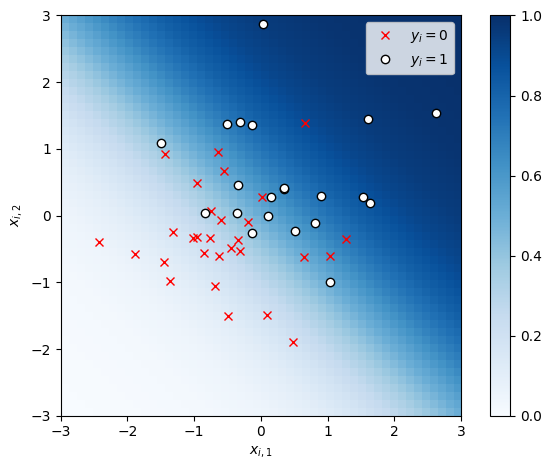

In [2]:
# Sample random covariates and data
torch.manual_seed(305 + ord('b'))
n = 50
X = Normal(0, 1).sample((n, 2))

# Fix true weights and variance
true_beta = torch.tensor([1.0, 1.0])
y = Bernoulli(logits=X @ true_beta).sample()

# Plot the data
x1s, x2s = torch.meshgrid(torch.linspace(-3, 3, 50), torch.linspace(-3, 3, 50))
x1x2 = torch.column_stack((x1s.ravel(), x2s.ravel()))
plt.imshow(torch.sigmoid(x1x2 @ true_beta).reshape(x1s.shape), 
           vmin=0, vmax=1, cmap="Blues", extent=(-3, 3, 3, -3))

plt.plot(X[y==0, 0], X[y==0, 1], 'rx', label=r"$y_i=0$")
plt.plot(X[y==1, 0], X[y==1, 1], 'wo', mec='k', mew=1, label=r"$y_i=1$")
plt.legend()
plt.xlabel(r"$x_{i,1}$")
plt.ylabel(r"$x_{i,2}$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal")
plt.colorbar()
plt.tight_layout()


In [3]:
# Set the prior 
sigmasq = 1.0

# Define the log joint
def log_joint(betas):
    # Add a batch dimension if necessary
    if betas.ndim == 1: betas = betas[None, :]

    # The log joint is the log likelihood plus the log prior
    lp = Bernoulli(logits=torch.einsum('np,mp->mn', X, betas)).log_prob(y).sum(axis=-1)
    lp += MultivariateNormal(torch.zeros(2), sigmasq * torch.eye(2)).log_prob(betas)
    return lp


Let's approximate the posterior with a Gaussian distribution,
\begin{align*}
q(\beta; \lambda) &= \mathrm{N}(\beta \mid m, V)
\end{align*}
where $\lambda = (m,V)$ are the variational parameters corresponding to the mean and covariance. 

:::{admonition} Unconstrained parameterization
To optimize the variational parameters with SGD, we want them to be unconstrained. However, here $V$ is a positive semidefinite matrix. To turn this into an unconstrained problem, we'll parameterize the covariance in terms of a square root, $V = LL^\top$ for $L \in \mathbb{R}^{2 \times 2}$. (We won't go so far as to constrain $L$ to be a lower triangular matrix with non-negative diagonals, but that would ensure a bijective mapping between $V$ and $L$.)
:::

In [4]:
from torch import nn
from torch.distributions import kl_divergence

class VariationalPosterior(nn.Module):
    def __init__(self, m, L):
        super().__init__()
        self.m = nn.Parameter(m)
        self.L = nn.Parameter(L)

    @property
    def posterior(self):
        return MultivariateNormal(self.m, self.L @ self.L.t())

    def elbo(self, n_samples=1):
        """
        Return the variational posterior distribution
        """
        q = self.posterior

        # Sample from the variational distribution
        beta_samples = q.rsample((n_samples,))
        
        # Compute the log joint and log variational
        elbo = log_joint(beta_samples).mean(axis=0)
        elbo -= kl_divergence(q, MultivariateNormal(torch.zeros(2), sigmasq * torch.eye(2)))
        return elbo


# Initialize the variational posterior
q = VariationalPosterior(torch.zeros(2), torch.eye(2))
optimizer = torch.optim.Adam(q.parameters(), lr=0.005)
elbos = []
for itr in trange(1000):
    # Compute the ELBO
    loss = -q.elbo()
    elbos.append(-loss.detach())
    
    # Update the variational parameters
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

elbos = torch.stack(elbos)    

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 728.13it/s]


Text(0, 0.5, 'ELBO')

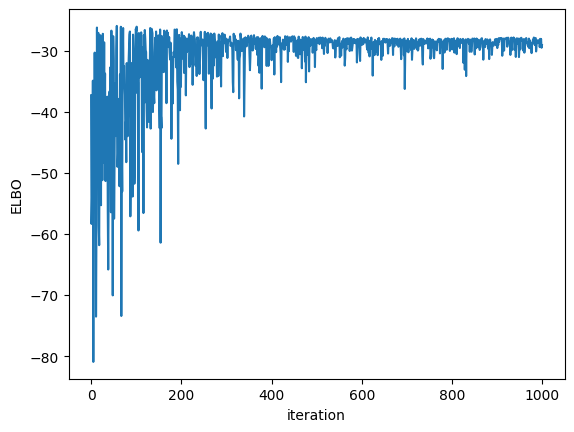

In [5]:
plt.plot(elbos)
plt.xlabel("iteration")
plt.ylabel("ELBO")

/var/folders/d1/fsjj9s5n5sdfzt5nrbrkq30m0000gn/T/ipykernel_19841/1482504668.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(beta1s, beta2s, lp_q, 25, colors='k', label='q')


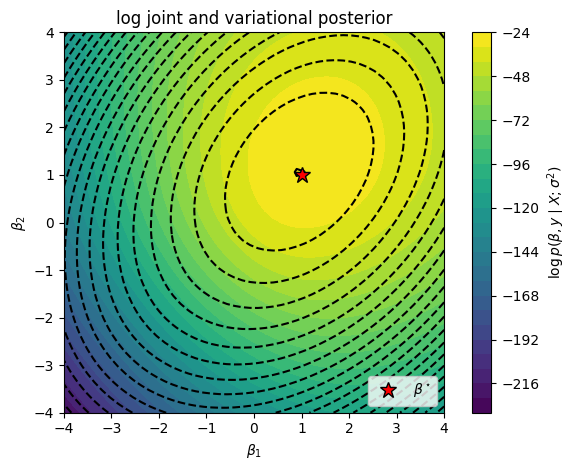

In [6]:

# Plot the log joint
beta1s, beta2s = torch.meshgrid(torch.linspace(-4, 4, 50), torch.linspace(-4, 4, 50))
beta12s = torch.column_stack((beta1s.ravel(), beta2s.ravel()))
# w_slice = torch.linspace(-4, 4)
lp = log_joint(beta12s).reshape(beta1s.shape)

# Plot the true log joint and the contours of the variational posterior
lp_q = q.posterior.log_prob(beta12s).reshape(beta1s.shape).detach()
plt.contour(beta1s, beta2s, lp_q, 25, colors='k', label='q')
plt.contourf(beta1s, beta2s, lp, 25)
plt.plot(true_beta[0], true_beta[1], 'r*', mec='k', ms=12, label=r"$\beta^\star$")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("log joint and variational posterior")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar(label=r"$\log p(\beta, y \mid X; \sigma^2)$")
plt.tight_layout()

### Exercises
    
**Exercise:** Come up with a reparameterization of an exponential distribution, $q(\theta; \lambda) = \mathrm{Exp}(\theta; \lambda)$ 

**Question:** Can you use the pathwise gradient estimator for a Bernoulli posterior, $q(\theta; \lambda) = \mathrm{Bern}(\theta; \lambda)$? 




## More Details

### Empirically comparing estimator variances
![Monte Carlo Gradient Estimation](../slides/09_vi/mc_gradient.png "Monte Carlo Gradient Estimation")
Empirical comparisons from {cite:t}`mohamed2020monte`.




### Working with mini-batches of data
Often, the ELBO involves a sum over data points,
\begin{align*}
    \cL(\mblambda) &= \E_q [\log p(\mbX, \mbtheta) - \log q(\mbtheta; \mblambda] \\
    &= \E_{q(\mbtheta; \mblambda)} \left[\sum_{n=1}^N \log p(\mbx_n \mid \mbtheta) + \log p(\mbtheta) - \log q(\mbtheta; \mblambda) \right]
    \\
    &= \sum_{n=1}^N \E_{q(\mbtheta; \mblambda)}[\log p(\mbx_n \mid \mbtheta)] - \KL{q(\mbtheta; \mblambda)}{p(\mbtheta)}
\end{align*}

We can view the sum as an expectation over data indices,
\begin{align*}
    \sum_{n=1}^N \E_{q(\mbtheta; \mblambda)}[\log p(\mbx_n \mid \mbtheta)] &= N \, \E_{n \sim \mathrm{Unif}(1,N)}[\E_{q(\mbtheta; \mblambda)}[\log p(\mbx_n \mid \mbtheta)]],
\end{align*}
and we can use Monte Carlo to approximate both expectations! (The same is true for Monte Carlo estimators of the gradient of the ELBO.)




### SGD convergence and extensions
When does SGD work? This is a well studied problem in stochastic optimization {cite:p}`bottou1998online, robbins1971convergence`.

Under relatively mild conditions, SGD converges to a **local minimum** if the step sizes obey the **Robbins-Monro condtions**,
\begin{align*}
    \sum_{i=0}^\infty \alpha_i &= \infty \qquad \text{and} \qquad
    \sum_{i=0}^\infty \alpha_i^2 < \infty
\end{align*}

There have been dozens of extensions to basic SGD including,
- SGD with momentum
- AdaGrad {cite:p}`duchi2011adaptive`
- RMSProp 
- Adam {cite:p}`kingma2014adam`



## Conclusion